# Fourier Transform

Useful guides:
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm
- https://medium.com/ntust-aivc/opencv-fourier-transform-d9811aaac2d5

In [50]:
# Standard library
import os

# Third-party libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage import color, exposure, io
from skimage.feature import hog
from skimage.filters import sobel
from skimage.transform import resize
from tabulate import tabulate
import imageio.v3 as iio

from IPython.display import display


1. Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize
the original image and its frequency spectrum (magnitude). Submit the images, and
explanation.

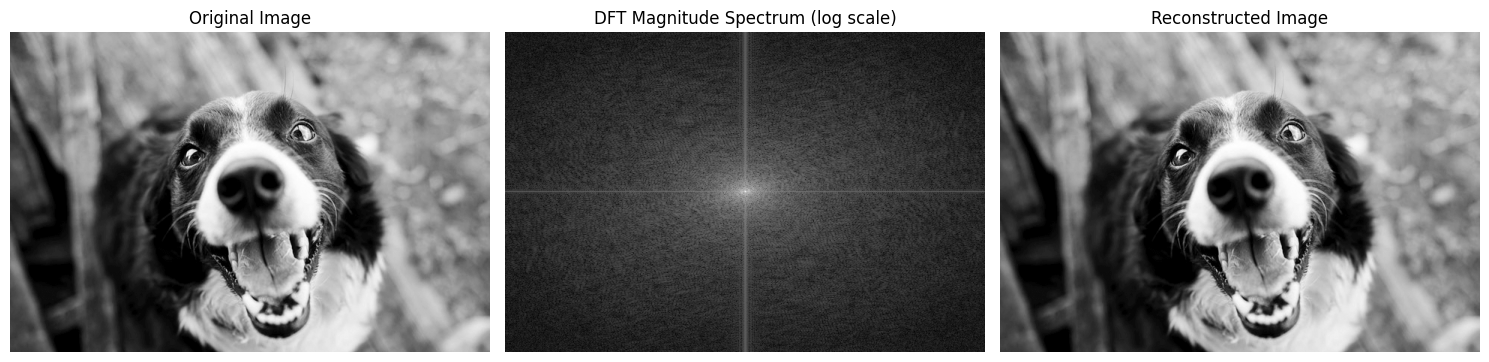

In [51]:
# Load image
img = iio.imread("img/grayscale/img1.png")

# Convert to grayscale if RGB
if img.ndim == 3:
    img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT and shift zero frequency to center
dft_result = fft2(img)
dft_shifted = fftshift(dft_result)

# Compute magnitude spectrum (for visualization)
magnitude = np.abs(dft_shifted)
magnitude_log = np.log(1 + magnitude)  # log-scale for better visibility

# Reconstruct image from inverse DFT
dft_ishift = ifftshift(dft_shifted)
img_reconstructed = ifft2(dft_ishift)
img_reconstructed = np.abs(img_reconstructed)

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(magnitude_log, cmap='gray')
plt.title("DFT Magnitude Spectrum (log scale)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_reconstructed, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

The 2D Discrete Fourier Transform (DFT) expresses a grayscale image as a sum of oriented 2D sinusoids, moving from the spatial domain (pixel intensities) to the frequency domain, where each point encodes a spatial frequency and direction. In the shown result, the log-magnitude spectrum has a bright center, indicating strong low-frequency energy that captures broad, smooth intensity variations (the dog’s overall shape), while the darker outer regions correspond to weaker high-frequency content (fine texture and noise). The faint vertical and horizontal streaks reveal dominant structures aligned with those axes. Taking the inverse DFT of the full complex spectrum reconstructs an image that matches the original, demonstrating that the transform is inherently lossless aside from tiny numerical errors.

2. Implement a low-pass filter in the frequency domain to remove high-frequency noise from
an image. Compare the filtered image with the original image. Submit images, and analysis
of the results.

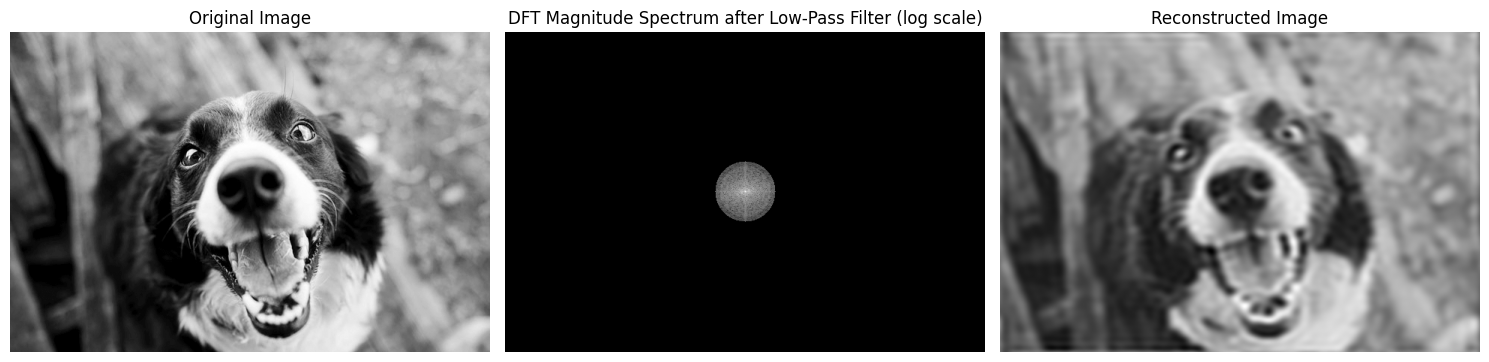

In [52]:
# Load image
img = iio.imread("img/grayscale/img1.png")
if img.ndim == 3:
    img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT and shift zero frequency to center
F = fft2(img)
Fshift = fftshift(F)

# Create a high-pass filter mask (1 outside circle, 0 inside)
M, N = img.shape
cy, cx = M // 2, N // 2
Y, X = np.ogrid[:M, :N]
radius = int(0.08 * min(M, N))     # tweak radius
mask = ((X - cx)**2 + (Y - cy)**2 <= radius**2).astype(float)  # 1 inside circle, 0 outside
r2 = max(radius + 6, radius + radius//6)
mask_soft = ((X - cx)**2 + (Y - cy)**2 <= r2**2).astype(float)
H = 0.5*mask + 0.5*mask_soft       # soft LP mask in [0,1]

# Apply high-pass filter in frequency domain
Gshift = Fshift * H

# Reconstruct image from filtered DFT
g = ifft2(ifftshift(Gshift))
g = np.real(g)
g = (g - g.min()) / (g.max() - g.min() + 1e-12)

# Compute magnitude spectrum after filtering 
spec_log = np.log1p(np.abs(Gshift))
spec_log = (spec_log - spec_log.min()) / (spec_log.max() - spec_log.min() + 1e-12)

# Visualize results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original Image"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(spec_log, cmap='gray'); plt.title("DFT Magnitude Spectrum after Low-Pass Filter (log scale)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(g, cmap='gray'); plt.title("Reconstructed Image"); plt.axis('off')
plt.tight_layout(); plt.show()


In the DFT, the low-pass filter keeps low frequencies (center of the spectrum) and removes high frequencies (edges) by applying a circular mask. This suppresses fine details and noise while preserving overall structure. As a result, the reconstructed image appears smoother and slightly blurred compared to the original. The bright center in the filtered spectrum confirms that only low frequencies remain.

3. Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image
and discuss the effects observed. Submit images, and explanation.

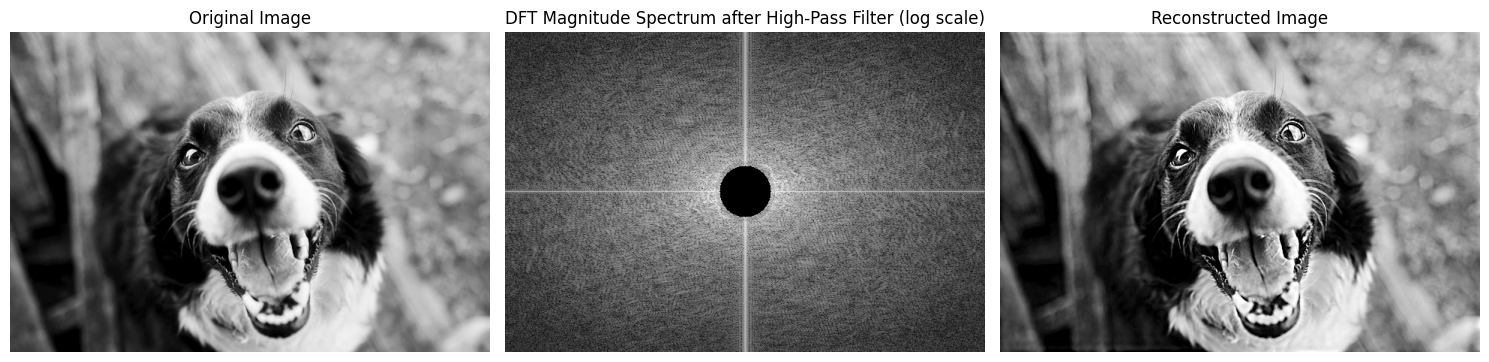

In [53]:
# Load image
img = iio.imread("img/grayscale/img1.png")
if img.ndim == 3:
    img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT and shift zero frequency to center
F = fft2(img)
Fshift = fftshift(F)

# Create a high-pass filter mask (1 outside circle, 0 inside)
M, N = img.shape
cy, cx = M // 2, N // 2
Y, X = np.ogrid[:M, :N]
radius = int(0.08 * min(M, N))
lp_core = ((X - cx)**2 + (Y - cy)**2 <= radius**2).astype(float)
r2 = max(radius + 6, radius + radius//6)
lp_soft = ((X - cx)**2 + (Y - cy)**2 <= r2**2).astype(float)
H_lp = 0.5*lp_core + 0.5*lp_soft
H_hp = 1.0 - H_lp

# Apply high-pass filter in frequency domain
Gshift = Fshift * H_hp

# IDFT of HP (edges)
g_hp = np.real(ifft2(ifftshift(Gshift)))

# High-boost (edge enhancement)
alpha = 0.6  
sharp = img + alpha * (g_hp - g_hp.mean())
sharp = np.clip(sharp, 0, 1)

# Compute magnitude spectrum after filtering
spec_log = np.log1p(np.abs(Gshift))
spec_log = (spec_log - spec_log.min()) / (spec_log.max() - spec_log.min() + 1e-12)

# Visualize results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original Image"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(spec_log, cmap='gray'); plt.title("DFT Magnitude Spectrum after High-Pass Filter (log scale)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(sharp, cmap='gray'); plt.title("Reconstructed Image"); plt.axis('off')
plt.tight_layout(); plt.show()


In the DFT, the high-pass filter removes low frequencies (center of the spectrum) and keeps high frequencies (edges of the spectrum) using a circular mask. This highlights edges and fine details while reducing smooth areas and lighting variations. The dark center in the filtered spectrum shows that low frequencies were suppressed. The reconstructed image appears sharper with enhanced edges, though some noise and slight ringing may occur.

4. Implement an image compression technique using Fourier Transform by selectively keeping
only a certain percentage of the Fourier coefficients. Evaluate the quality of the
reconstructed image as you vary the percentage of coefficients used. Submit the images,
and your observations on image quality and compression ratio.

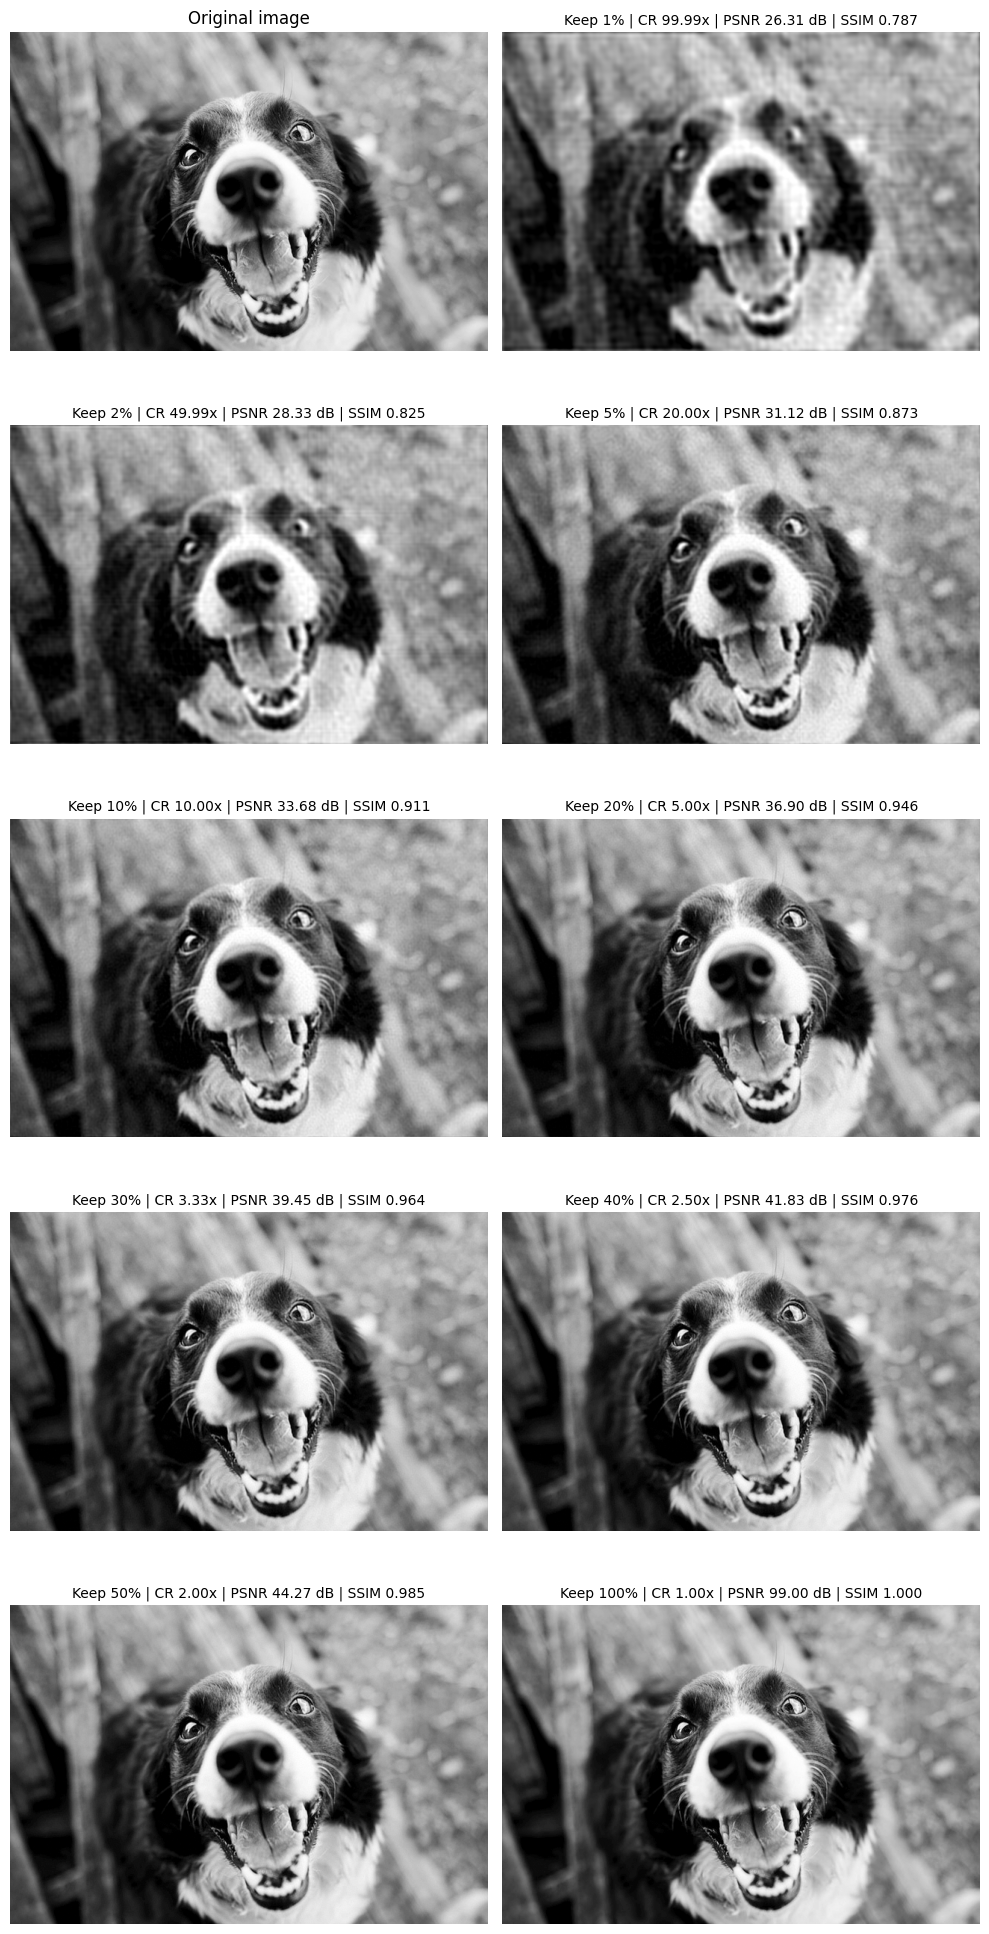

| % Coefficients Kept   | Kept/Total (%)   | CR (Total/Kept)   |      MSE | PSNR (dB)   |   SSIM |
|-----------------------|------------------|-------------------|----------|-------------|--------|
| 1%                    | 1.00%            | 99.99x            | 0.002341 | 26.31 dB    |  0.787 |
| 2%                    | 2.00%            | 49.99x            | 0.001471 | 28.33 dB    |  0.825 |
| 5%                    | 5.00%            | 20.00x            | 0.000773 | 31.12 dB    |  0.873 |
| 10%                   | 10.00%           | 10.00x            | 0.000429 | 33.68 dB    |  0.911 |
| 20%                   | 20.00%           | 5.00x             | 0.000204 | 36.90 dB    |  0.946 |
| 30%                   | 30.00%           | 3.33x             | 0.000114 | 39.45 dB    |  0.964 |
| 40%                   | 40.00%           | 2.50x             | 6.6e-05  | 41.83 dB    |  0.976 |
| 50%                   | 50.00%           | 2.00x             | 3.7e-05  | 44.27 dB    |  0.985 |
| 100%    

In [54]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
from tabulate import tabulate
import math

# ------------------ Utils: MSE / PSNR / SSIM ------------------

def mse(x, y):
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    return np.mean((x - y) ** 2)

def psnr(x, y):
    """PSNR for images in [0,1]."""
    m = mse(x, y)
    if m <= 1e-12:  # identical
        return 99.0
    return 10 * np.log10(1.0 / m)

def _gaussian_kernel_1d(size=11, sigma=1.5):
    ax = np.arange(-(size//2), size//2 + 1, dtype=np.float64)
    g = np.exp(-(ax**2) / (2 * sigma**2))
    g /= g.sum()
    return g

def _conv2_separable(img, k):
    """2D separabel konvolusjon med 1D-kjerne k, reflect-padding."""
    pad = len(k) // 2
    # radvis
    tmp = np.pad(img, ((0, 0), (pad, pad)), mode='reflect')
    tmp = np.apply_along_axis(lambda m: np.convolve(m, k, mode='valid'), axis=1, arr=tmp)
    # kolonnevis
    tmp = np.pad(tmp, ((pad, pad), (0, 0)), mode='reflect')
    out = np.apply_along_axis(lambda m: np.convolve(m, k, mode='valid'), axis=0, arr=tmp)
    return out

def ssim(x, y, size=11, sigma=1.5):
    """
    SSIM for gråtonebilder i [0,1], vindusbasert (Gauss).
    Returnerer global MSSIM (gjennomsnitt av SSIM-kartet).
    """
    x = x.astype(np.float64)
    y = y.astype(np.float64)

    k = _gaussian_kernel_1d(size=size, sigma=sigma)

    mu_x = _conv2_separable(x, k)
    mu_y = _conv2_separable(y, k)

    mu_x2 = mu_x * mu_x
    mu_y2 = mu_y * mu_y
    mu_xy = mu_x * mu_y

    sigma_x2 = _conv2_separable(x * x, k) - mu_x2
    sigma_y2 = _conv2_separable(y * y, k) - mu_y2
    sigma_xy = _conv2_separable(x * y, k) - mu_xy

    # L = 1 (bilder er normalisert), standardkonstanter
    C1 = (0.01 ** 2)
    C2 = (0.03 ** 2)

    num = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
    den = (mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2)
    ssim_map = num / (den + 1e-12)
    return float(np.mean(ssim_map))

# ------------------ Load & prep image ------------------

# Load image
img = iio.imread("img/grayscale/img1.png")

# Convert to grayscale if RGB
if img.ndim == 3:
    img = img[..., :3]
    img = np.dot(img, [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# ------------------ FFT & helpers ------------------

F = fft2(img)
mag = np.abs(F)
total = mag.size

def keep_top_percent(F, pct):
    """Keep the top 'pct' percent of Fourier coefficients by magnitude."""
    mag_local = np.abs(F)
    total_local = mag_local.size
    if pct >= 100:
        mask = np.ones_like(F, dtype=bool)
        kept = total_local
    else:
        k = max(1, int(np.ceil(total_local * pct / 100.0)))
        thresh = np.partition(mag_local.ravel(), total_local - k)[total_local - k]  # kth largest threshold
        mask = (mag_local >= thresh)
        kept = int(mask.sum())
    Fc = F * mask
    rec = np.real(ifft2(Fc))
    rec = np.clip(rec, 0, 1)
    return rec, mask, kept

# ------------------ Sweep percentages ------------------

percents = [1, 2, 5, 10, 20, 30, 40, 50, 100]
results = []
for p in percents:
    rec, mask, kept = keep_top_percent(F, p)
    m = mse(img, rec)
    results.append({
        "pct": p,
        "rec": rec,
        "kept": kept,
        "frac_kept": kept / total,     # andel beholdt
        "CR": (total / kept),          # Compression Ratio = total/kept
        "MSE": m,
        "PSNR": psnr(img, rec),
        "SSIM": ssim(img, rec),
    })

# ------------------ Plot original + reconstructions ------------------

nplots = len(percents) + 1  # original + reconstructions
cols = 2
rows = math.ceil(nplots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
axes = axes.ravel()

# Original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original image")
axes[0].axis('off')

# Reconstructed images
# Reconstructed images
for i, r in enumerate(results, start=1):
    axes[i].imshow(r["rec"], cmap='gray')
    axes[i].set_title(
        f"Keep {r['pct']}% | CR {r['CR']:.2f}x | PSNR {r['PSNR']:.2f} dB | SSIM {r['SSIM']:.3f}",
        fontsize=10
    )
    axes[i].axis('off')

# Hide unused subplots
for j in range(len(results) + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# ------------------ Print results table ------------------

table_data = [
    [
        f"{r['pct']}%",
        f"{r['frac_kept']*100:.2f}%",     # Kept/Total (%)
        f"{r['CR']:.2f}x",                # Compression Ratio
        f"{r['MSE']:.6f}",                # MSE
        f"{r['PSNR']:.2f} dB",            # PSNR
        f"{r['SSIM']:.3f}",               # SSIM
    ]
    for r in results
]
headers = ["% Coefficients Kept", "Kept/Total (%)", "CR (Total/Kept)", "MSE", "PSNR (dB)", "SSIM"]
print(tabulate(table_data, headers=headers, tablefmt="github"))


As the proportion of retained Fourier coefficients increases, the reconstructed image quality improves gradually. When keeping only 1–5% of the coefficients, the image remains recognizable but appears blurred and lacks detail. At 10–20%, most structures and textures are restored, showing a noticeable enhancement in visual quality. From 30–50%, the reconstruction becomes nearly indistinguishable from the original, with PSNR values exceeding 40 dB. These results demonstrate that the essential visual information is concentrated in a small fraction of large-magnitude Fourier coefficients, enabling strong compression with minimal perceptual loss — effectively balancing compression ratio and image fidelity.

# PCA

Select a set of grayscale images (e.g., faces, landscapes, or any other category).
Normalize the images by scaling pixel values to a range [0, 1].

In [55]:
import cv2

faces = {}
            
for filename in [os.path.join('img/faces', f) for f in os.listdir('img/faces')]:
    faces[filename] = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    faces[filename] = cv2.resize(faces[filename], (128,128))
    faces[filename] = cv2.normalize(faces[filename], None, 0, 1, cv2.NORM_MINMAX)

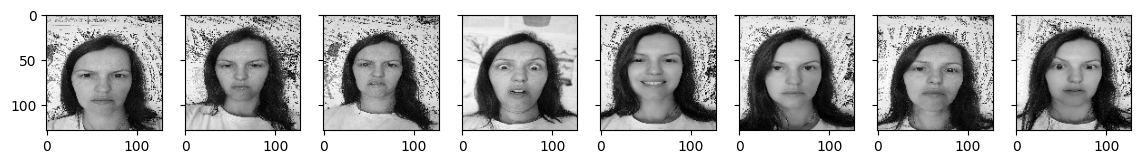

In [56]:
fig, axes = plt.subplots(1,8,sharex=True,sharey=True,figsize=(14,4))
faceimages = list(faces.values())[:8]
for i in range(8):
    axes[i].imshow(faceimages[i], cmap="gray")
plt.show()

In [57]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)
print(list(faces.keys())[:9])
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))

Face image shape: (128, 128)
['img/faces\\Anger.jpg', 'img/faces\\Contempt.jpg', 'img/faces\\Disgust.jpg', 'img/faces\\Fear.jpg', 'img/faces\\Happy.jpg', 'img/faces\\Neutral.jpg', 'img/faces\\Sad.jpg', 'img/faces\\Surprised.jpg']
Number of classes: 1
Number of pictures: 8


## PCA Implementation:
Write a Python function to perform PCA on the images.
Implement the following steps:

1. Convert the image into a 2D matrix where each row represents an image and each column
represents a pixel value

In [58]:
facematrix = np.array([img.flatten() for img in faces.values()])
facematrix

array([[0.89185536, 0.83888906, 0.8603644 , ..., 0.46532917, 0.5526744 ,
        0.7094227 ],
       [0.71946037, 0.79581714, 0.83665985, ..., 0.5482967 , 0.36582887,
        0.75940984],
       [0.03948095, 0.4431867 , 0.8387631 , ..., 0.7013927 , 0.7289711 ,
        0.75363517],
       ...,
       [0.43659124, 0.57136196, 0.87871253, ..., 0.54377407, 0.5940102 ,
        0.6103516 ],
       [0.8279164 , 0.8209189 , 0.8336249 , ..., 0.57075775, 0.59620047,
        0.57054293],
       [0.82765573, 0.8175506 , 0.8309104 , ..., 0.7094015 , 0.48076627,
        0.45696044]], shape=(8, 16384), dtype=float32)

2. Compute the covariance matrix of the image data.

In [59]:
faces_mean = np.mean(facematrix, axis=0)
facematrix_centered = facematrix - faces_mean
cov_matrix = np.cov(facematrix_centered.T, rowvar=False)
cov_matrix

array([[ 3.58577672e-02, -8.72304546e-03, -2.84653024e-03,
         1.77496260e-04, -1.13729119e-02, -9.48826372e-03,
         4.03929839e-03, -7.64381060e-03],
       [-8.72304546e-03,  4.09023101e-02,  6.61841489e-03,
        -4.02018980e-03, -3.11896660e-03, -1.41718488e-02,
        -1.18045304e-02, -5.68214486e-03],
       [-2.84653024e-03,  6.61841489e-03,  4.45516821e-02,
        -3.54583123e-03, -8.39589202e-03, -1.38356773e-02,
        -1.02577424e-02, -1.22884236e-02],
       [ 1.77496260e-04, -4.02018980e-03, -3.54583123e-03,
         2.00405171e-02, -4.14160888e-03, -5.27586986e-03,
        -5.85905134e-05, -3.17592274e-03],
       [-1.13729119e-02, -3.11896660e-03, -8.39589202e-03,
        -4.14160888e-03,  4.24798290e-02, -1.39273337e-03,
        -1.37514717e-02, -3.06244709e-04],
       [-9.48826372e-03, -1.41718488e-02, -1.38356773e-02,
        -5.27586986e-03, -1.39273337e-03,  4.48333277e-02,
        -1.24289794e-03,  5.73963563e-04],
       [ 4.03929839e-03, -1.180453

3. Calculate the eigenvalues and eigenvectors of the covariance matrix.

In [60]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
display(eigenvalues)
display(eigenvectors)

array([7.29950778e-02, 6.22807802e-02, 6.29771264e-15, 4.16638603e-02,
       3.79726531e-02, 2.18630580e-02, 2.98240450e-02, 2.69199079e-02])

array([[-0.02044878,  0.51363218,  0.35355339, -0.29850803, -0.35375307,
        -0.19106913,  0.39030681,  0.45570685],
       [-0.49372774, -0.22336729,  0.3535534 , -0.01005952,  0.57992104,
        -0.09372569,  0.48293525, -0.05403147],
       [-0.58843352,  0.07145241,  0.35355339,  0.46193657, -0.32907452,
        -0.09174716, -0.43992021,  0.00421643],
       [ 0.00309338,  0.11099839,  0.35355339, -0.1320852 , -0.02152565,
         0.91282337, -0.01595048, -0.10610855],
       [ 0.07934512, -0.62737593,  0.35355339, -0.41936376, -0.45193093,
        -0.16259655,  0.00522053, -0.26178498],
       [ 0.53360445, -0.17642288,  0.35355339,  0.67717388, -0.05893859,
        -0.00522365,  0.29882934,  0.08818598],
       [ 0.25188729,  0.4732178 ,  0.35355339, -0.08217658,  0.21695943,
        -0.280919  , -0.17216437, -0.65210219],
       [ 0.23467982, -0.14213467,  0.35355339, -0.19691737,  0.41834227,
        -0.08754217, -0.54925689,  0.52591792]])

4. Sort the eigenvectors based on the eigenvalues in descending order.

In [61]:
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
display(eigenvalues)
display(eigenvectors)

array([7.29950778e-02, 6.22807802e-02, 4.16638603e-02, 3.79726531e-02,
       2.98240450e-02, 2.69199079e-02, 2.18630580e-02, 6.29771264e-15])

array([[-0.02044878,  0.51363218, -0.29850803, -0.35375307,  0.39030681,
         0.45570685, -0.19106913,  0.35355339],
       [-0.49372774, -0.22336729, -0.01005952,  0.57992104,  0.48293525,
        -0.05403147, -0.09372569,  0.3535534 ],
       [-0.58843352,  0.07145241,  0.46193657, -0.32907452, -0.43992021,
         0.00421643, -0.09174716,  0.35355339],
       [ 0.00309338,  0.11099839, -0.1320852 , -0.02152565, -0.01595048,
        -0.10610855,  0.91282337,  0.35355339],
       [ 0.07934512, -0.62737593, -0.41936376, -0.45193093,  0.00522053,
        -0.26178498, -0.16259655,  0.35355339],
       [ 0.53360445, -0.17642288,  0.67717388, -0.05893859,  0.29882934,
         0.08818598, -0.00522365,  0.35355339],
       [ 0.25188729,  0.4732178 , -0.08217658,  0.21695943, -0.17216437,
        -0.65210219, -0.280919  ,  0.35355339],
       [ 0.23467982, -0.14213467, -0.19691737,  0.41834227, -0.54925689,
         0.52591792, -0.08754217,  0.35355339]])


5. Select the top k eigenvectors to form the principal components.

In [62]:
features = 8
pcs = eigenvectors[:, :8]
pcs

array([[-0.02044878,  0.51363218, -0.29850803, -0.35375307,  0.39030681,
         0.45570685, -0.19106913,  0.35355339],
       [-0.49372774, -0.22336729, -0.01005952,  0.57992104,  0.48293525,
        -0.05403147, -0.09372569,  0.3535534 ],
       [-0.58843352,  0.07145241,  0.46193657, -0.32907452, -0.43992021,
         0.00421643, -0.09174716,  0.35355339],
       [ 0.00309338,  0.11099839, -0.1320852 , -0.02152565, -0.01595048,
        -0.10610855,  0.91282337,  0.35355339],
       [ 0.07934512, -0.62737593, -0.41936376, -0.45193093,  0.00522053,
        -0.26178498, -0.16259655,  0.35355339],
       [ 0.53360445, -0.17642288,  0.67717388, -0.05893859,  0.29882934,
         0.08818598, -0.00522365,  0.35355339],
       [ 0.25188729,  0.4732178 , -0.08217658,  0.21695943, -0.17216437,
        -0.65210219, -0.280919  ,  0.35355339],
       [ 0.23467982, -0.14213467, -0.19691737,  0.41834227, -0.54925689,
         0.52591792, -0.08754217,  0.35355339]])

6. Project the original images onto the lower-dimensional subspace defined by the selected principal components.

In [63]:
eigenfaces = (facematrix_centered.T @ pcs).T
eigenfaces

array([[ 2.88391902e-01,  9.91926642e-02,  1.66318630e-02, ...,
        -4.12995597e-02,  1.06362315e-02, -2.01584729e-01],
       [ 2.17706564e-01,  4.02397064e-02,  1.65498630e-02, ...,
        -6.22935027e-02,  5.99075658e-02,  1.84036626e-02],
       [-5.45741926e-01, -3.40840002e-01,  3.70164479e-02, ...,
         2.50578856e-03,  6.52341613e-02,  2.65184925e-02],
       ...,
       [ 6.06191160e-02, -1.11915832e-02,  2.23348137e-02, ...,
        -7.65059197e-03, -9.22067744e-02, -4.71530754e-02],
       [ 9.97884430e-02,  2.94230436e-02, -2.21181351e-02, ...,
         1.63098982e-01,  1.81934138e-01,  1.20173707e-01],
       [ 7.52908212e-08, -8.32240893e-08,  1.05530983e-07, ...,
         1.92209417e-08,  9.17105225e-08,  2.53447988e-07]],
      shape=(8, 16384))

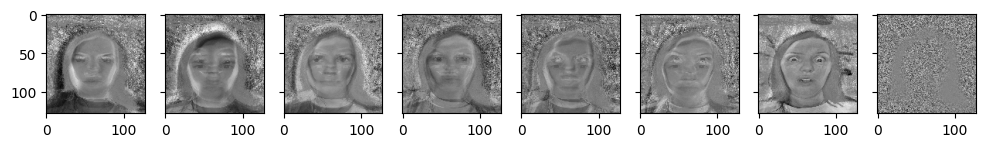

In [64]:
facematrix_reduced = (facematrix_centered.T @ pcs).T

fig, axes = plt.subplots(1, features, sharex=True, sharey=True, figsize=(12, 4))
for i in range(features):
    axes[i].imshow(facematrix_reduced[i].reshape(faceshape), cmap="gray")
plt.show()

## Reconstruction of Images:

1. Using the selected principal components, reconstruct the images.

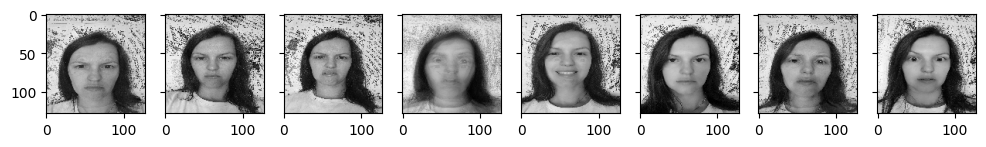

In [65]:
k = 6
facematrix_reconstructed = (pcs[:, :k] @ facematrix_reduced[:k]) + faces_mean

fig, axes = plt.subplots(1, features, sharex=True, sharey=True, figsize=(12, 4))
for i in range(features):
    axes[i].imshow(facematrix_reconstructed[i].reshape(faceshape), cmap="gray")
plt.show()

2. Compare the reconstructed images with the original images to observe the effects of
dimensionality reduction.

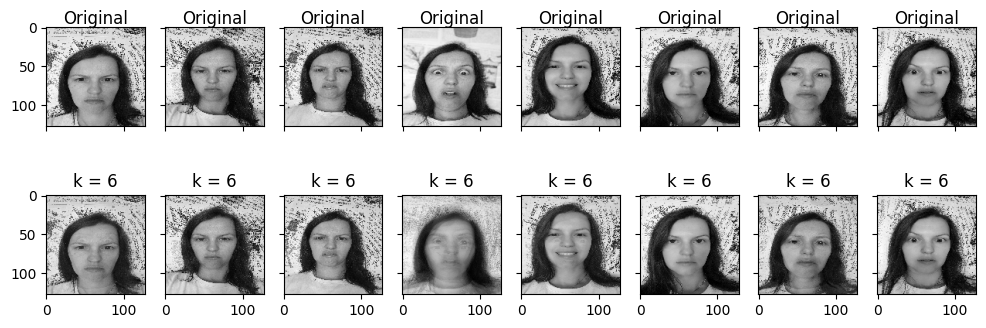

In [66]:
fig, axes = plt.subplots(2, features, sharex=True, sharey=True, figsize=(12, 4))

for i in range(features):
    axes[0][i].imshow(faceimages[i], cmap="gray")
    axes[0][i].set_title("Original", y=0.95)
    axes[1][i].imshow(facematrix_reconstructed[i].reshape(faceshape), cmap="gray")
    axes[1][i].set_title(f"k = {k}")
plt.show()

## Experimentation:

1. Vary the number of principal components (k) and observe the impact on the quality of the
reconstructed images.

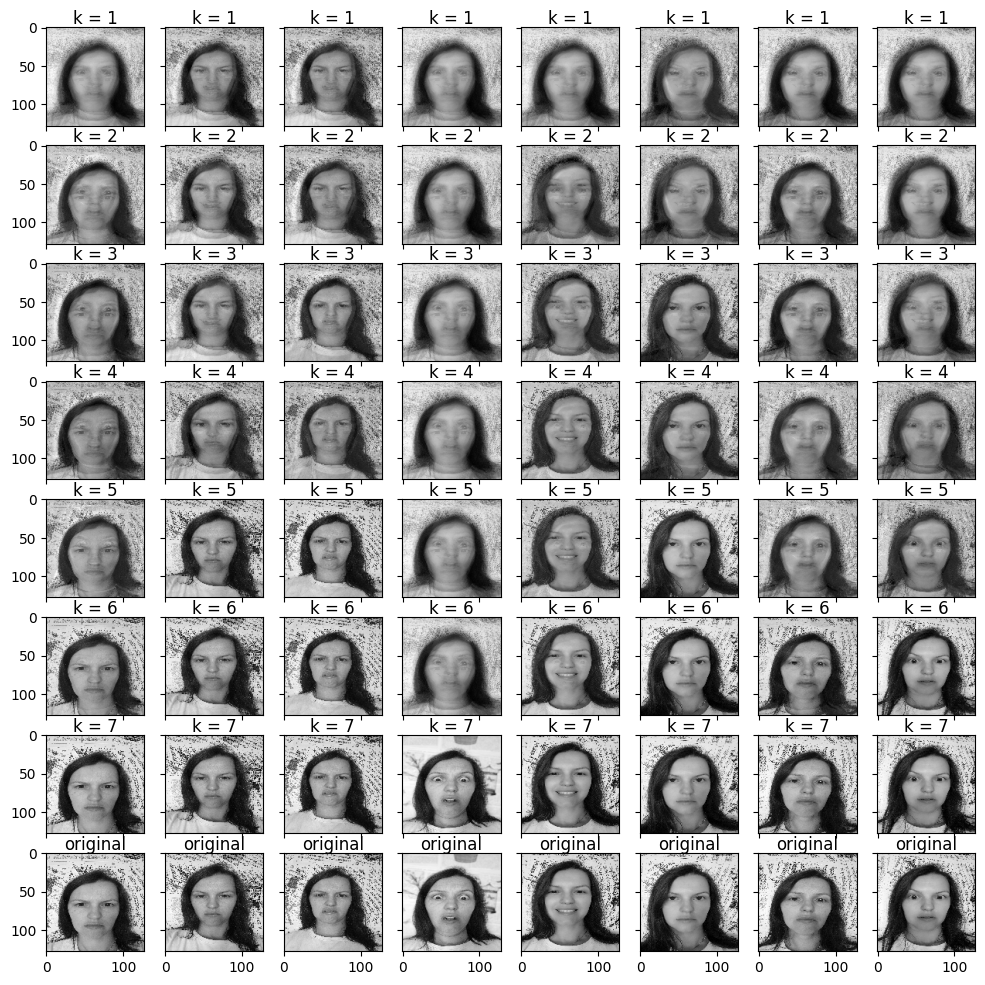

In [67]:
facematrix_reconstructed_k = {}

for i in range(1, features + 1):
    facematrix_reconstructed_k[i] = (pcs[:, :i] @ facematrix_reduced[:i]) + faces_mean

fig, axes = plt.subplots(features, features, sharex=True, sharey=True, figsize=(12, 12))

for i in range(features):
    for j in range(features):
        axes[i][j].imshow(facematrix_reconstructed_k[i + 1][j].reshape(faceshape), cmap="gray")
        axes[i][j].set_title(f"k = {i + 1}" if i <7 else 'original', y=0.95)
plt.show()

2. Plot the variance explained by the principal components and determine the optimal number
of components that balances compression and quality.

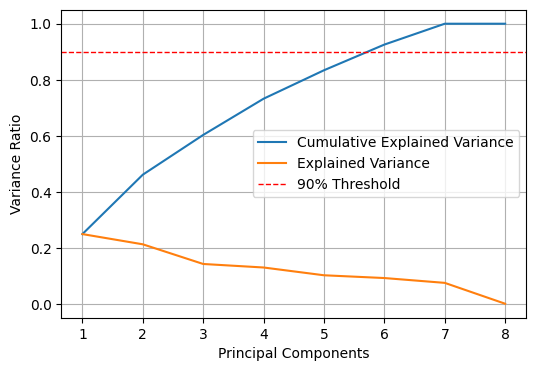

In [68]:
total_variance = np.sum(eigenvalues)
explained_variance = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance)

threshold = 0.90

plt.figure(figsize=(6,4))
plt.plot(range(1, features+1), cumulative_variance, label="Cumulative Explained Variance")
plt.plot(range(1, features+1), explained_variance, label="Explained Variance")
plt.axhline(threshold, color="r", ls="--", lw=1, label=f"{round(threshold * 100)}% Threshold")
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio")
plt.grid(True)
plt.legend()
plt.show()


## Visual Analasys

1. Display the original images alongside the reconstructed images for different values of k.

2. Comment on the visual quality of the images and how much information is lost during
compression.

## Error Analasys

1. Compute the Mean Squared Error (MSE) between the original and reconstructed images.

In [69]:
mse_list = []

for i in range(1, features + 1):
    mse = np.mean((facematrix - facematrix_reconstructed_k[i])**2)
    mse_list.append(mse)

for i, mse in zip(range(1, features + 1), mse_list):
    print(f"k={i}, MSE={mse:.6f}")

k=1, MSE=0.028469
k=2, MSE=0.020458
k=3, MSE=0.015222
k=4, MSE=0.010388
k=5, MSE=0.006643
k=6, MSE=0.003276
k=7, MSE=0.000000
k=8, MSE=0.000000


2. Analyze the trade-off between compression and reconstruction error.

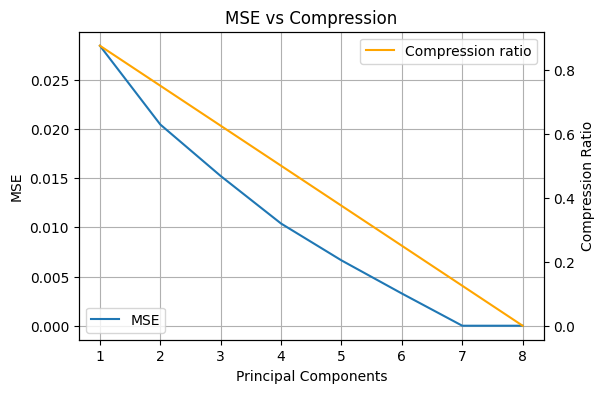

In [70]:
fig, ax1 = plt.subplots(figsize=(6,4))
plt.xlabel("Principal Components")
plt.grid(True)

ax1.plot(range(1, features + 1), mse_list, label='MSE')
ax1.set_ylabel("MSE")
ax1.legend(loc="lower left")

ax2 = plt.gca().twinx()
ax2.plot(range(1, features + 1), [1 - (i / features) for i in range(1, features + 1)], color='orange', label='Compression ratio')
ax2.set_ylabel("Compression Ratio")
ax2.legend(loc="upper right")

plt.title("MSE vs Compression")
plt.show()

Z shape: (8, 6)


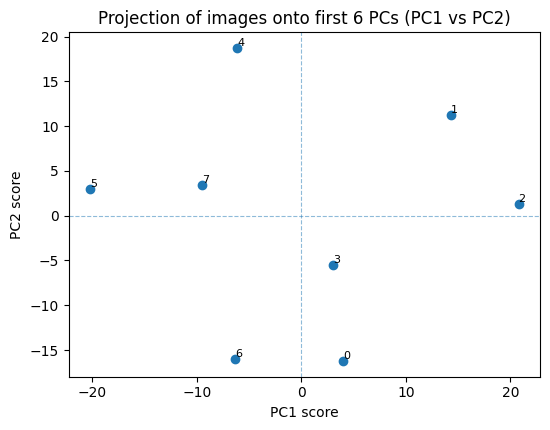

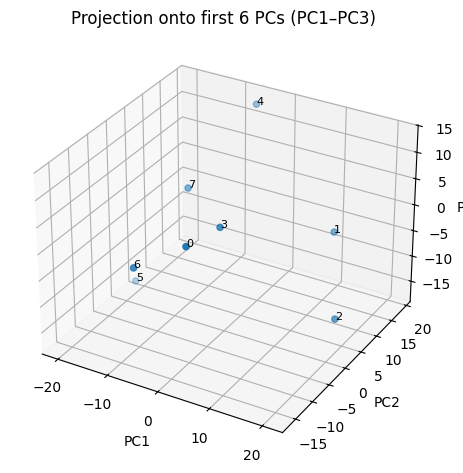

      PC1     PC2     PC3     PC4     PC5     PC6
0   4.013 -16.236   7.782  -5.997 -10.274 -10.139
1  14.295  11.233  -2.243  15.215 -10.180   1.643
2  20.790   1.308 -11.277  -9.312   8.891  -1.145
3   3.029  -5.504   4.951  -2.472   3.083   5.231
4  -6.113  18.736  12.919 -10.168  -0.896   4.683
5 -20.217   2.963 -16.926  -4.255  -6.060  -1.177
6  -6.342 -15.957   0.769   6.455   3.384  12.371
7  -9.456   3.457   4.025  10.534  12.051 -11.467


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------- 0) Hent/normaliser X og mu ----------
h, w = faceshape
d = h * w

# X som (n, d)
X = facematrix if facematrix.shape[1] == d else facematrix.T
X = X.astype(np.float64)
n, d_check = X.shape
assert d_check == d, f"X har d={d_check}, forventet d={d}"

# Middelbilde (bruk eksisterende mu hvis den finnes)
try:
    mu
except NameError:
    mu = X.mean(axis=0, keepdims=True).astype(np.float64)
X0 = X - mu

# ---------- 1) Finn/lag komponentbasis i pikselrom ----------
def _ensure_row_orthonormal(P_):
    Q, _ = np.linalg.qr(P_.T)  # (d, k)
    return Q.T                 # (k, d)

if 'P' in globals():
    P_use = _ensure_row_orthonormal(np.asarray(P, dtype=np.float64))
elif 'Vt' in globals():
    P_use = _ensure_row_orthonormal(np.asarray(Vt, dtype=np.float64))
elif 'pc' in globals():
    pc_arr = np.asarray(pc, dtype=np.float64)
    if pc_arr.shape[1] == n:         # (k_all, n) sample-rom
        P_unnorm = pc_arr @ X0       # -> (k_all, d)
    elif pc_arr.shape[0] == n:       # (n, k_all) sample-rom
        P_unnorm = pc_arr.T @ X0     # -> (k_all, d)
    elif pc_arr.shape[1] == d:       # (k_all, d) allerede pikselrom
        P_unnorm = pc_arr
    elif pc_arr.shape[0] == d:       # (d, k_all) transponert
        P_unnorm = pc_arr.T
    else:
        raise ValueError("pc matcher verken n eller d; kan ikke konstruere P.")
    P_use = _ensure_row_orthonormal(P_unnorm)
else:
    # Ingen P / Vt / pc? Lag basis fra SVD av dine faktiske data.
    U, S, Vt = np.linalg.svd(X0, full_matrices=False)  # X0 = U S Vt
    P_use = _ensure_row_orthonormal(Vt.astype(np.float64))

# ---------- 2) Velg k og PROJISÉR ----------
k = min(6, P_use.shape[0])   # endre hvis du vil
Pk = P_use[:k, :]            # (k, d)

# Lavdimensjonale koordinater (scores): Z \in R^{n x k}
Z = X0 @ Pk.T
print("Z shape:", Z.shape)

# ---------- 3) VISUALISER: PC1 vs PC2 ----------
plt.figure(figsize=(5.6, 4.4))
plt.scatter(Z[:, 0], Z[:, 1])
for i, (xv, yv) in enumerate(Z[:, :2]):
    plt.text(xv, yv, str(i), fontsize=8, ha='left', va='bottom')
plt.axhline(0, ls='--', lw=0.8, alpha=0.5)
plt.axvline(0, ls='--', lw=0.8, alpha=0.5)
plt.xlabel("PC1 score")
plt.ylabel("PC2 score")
plt.title(f"Projection onto first k={k} PCs - Visualized as PC1 vs PC2)")
plt.tight_layout()
plt.show()

# ---------- 4) (Valgfritt) 3D-plot hvis k >= 3 ----------
if k >= 3:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(6.0, 4.8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2])
    for i in range(n):
        ax.text(Z[i,0], Z[i,1], Z[i,2], str(i), fontsize=8)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    ax.set_title(f"Projection onto first {k} PCs (PC1–PC3)")
    plt.tight_layout(); plt.show()

# ---------- 5) (Valgfritt) tabell med scores ----------
dfZ = pd.DataFrame(Z, columns=[f"PC{i+1}" for i in range(k)])
print(dfZ.round(3))
# dfZ.to_csv("projection_scores.csv", index=False)


# Image processing

## HOG Features

1. Write a Python script to compute the HOG features of a given image using a library such as
OpenCV or scikit-image.

In [13]:
def compute_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    """Compute HOG features of a given image"""
    # Convert to grayscale if RGB
    if image.ndim == 3:
        image = color.rgb2gray(image)

    # Ensure values are in [0,1]
    image = image.astype(np.float32)
    if image.max() > 1.0:
        image /= 255.0

    # Compute HOG features
    if visualize:
        features, hog_image = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm="L2-Hys",
            visualize=True,
            feature_vector=True
        )
        return features, hog_image
    else:
        features = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm="L2-Hys",
            visualize=False,
            feature_vector=True
        )
        return features

2. Apply your implementation to at least three different images, including both simple and
complex scenes.

In [14]:
# Paths to images
folder_path = "img/hog"

# List all files ending with .png in the folder, sorted alphabetically
images_paths = sorted(
    [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
)

# Store results
hog_results = []

for path in images_paths:
    image = io.imread(path)
    features, hog_image = compute_hog_features(image, visualize=True)
    hog_results.append((path, image, hog_image, features))


3. Visualize the original image, the gradient image, and the HOG feature image.

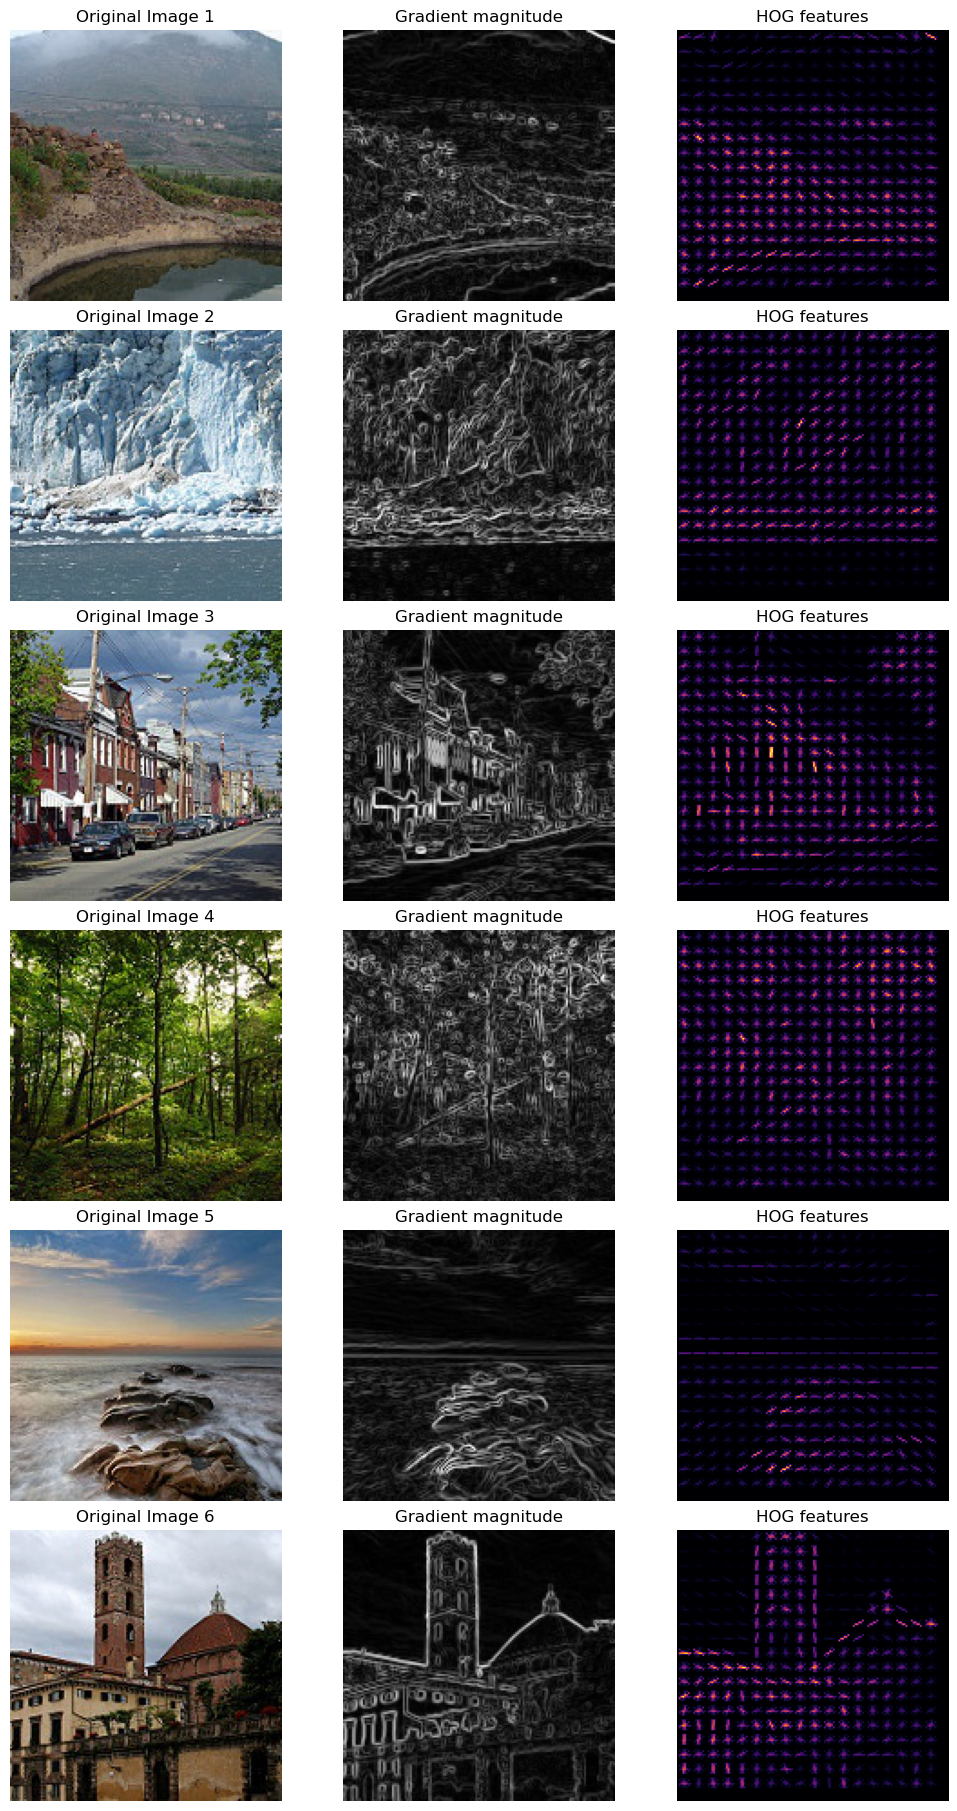

In [15]:
# Visualize results
num_images_to_show = len(hog_results)
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(10, 3 * num_images_to_show), constrained_layout=True)

for i, (path, img, hog_img, _) in enumerate(hog_results):
    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img

    gradient = sobel(gray)

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")

    # Gradient image
    axes[i, 1].imshow(gradient, cmap="gray")
    axes[i, 1].set_title("Gradient magnitude")
    axes[i, 1].axis("off")

    # HOG visualization
    axes[i, 2].imshow(hog_img, cmap="inferno")
    axes[i, 2].set_title("HOG features")
    axes[i, 2].axis("off")

plt.show()


4. Compare the HOG features extracted from different images. Discuss the impact of varying
parameters like cell size, block size, and the number of bins on the resulting HOG
descriptors.

The HOG results show that each image’s feature map emphasizes strong edges and structural details such as building outlines, tree trunks, and rock boundaries. Images with simple, well-defined edges (like the rocks or buildings) produce clear, organized gradient patterns, while complex natural scenes (like forests) result in denser and less distinct HOG representations.

Smaller cell sizes capture fine textures and subtle details but increase feature complexity, while larger cells focus on broader edge structures. Similarly, increasing the number of bins improves directional precision but enlarges the feature vector. Overall, varying cell size, block size, and orientation bins changes the balance between detail sensitivity and computational efficiency in the resulting HOG descriptors.

## Local Binary Patterns (LBP)

1. Write a Python function to compute the LBP of a given grayscale image. Use the basic 8-
neighbor LBP method.

In [16]:
def compute_lbp(image):
    """Compute basic 8-neighbor LBP for a grayscale image"""
    img = image.astype(np.float32)
    if img.ndim != 2:
        raise ValueError("LBP forventer et 2D gråtonebilde.")
    H, W = img.shape

    # Pad for edges
    padded = np.pad(img, pad_width=1, mode='edge')

    # LBP-buffer som uint8
    lbp_image = np.zeros((H, W), dtype=np.uint8)

    # 8-neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0,  1), ( 1,  1), ( 1,  0),
                 ( 1, -1), ( 0, -1)]

    for idx, (dy, dx) in enumerate(neighbors):
        neighbor = padded[1 + dy:H + 1 + dy, 1 + dx:W + 1 + dx]
        bit = (neighbor >= img).astype(np.uint8) 
        lbp_image |= (bit << (7 - idx))         

    return lbp_image

2. Your function should output the LBP image, where each pixel is replaced by its
corresponding LBP value.

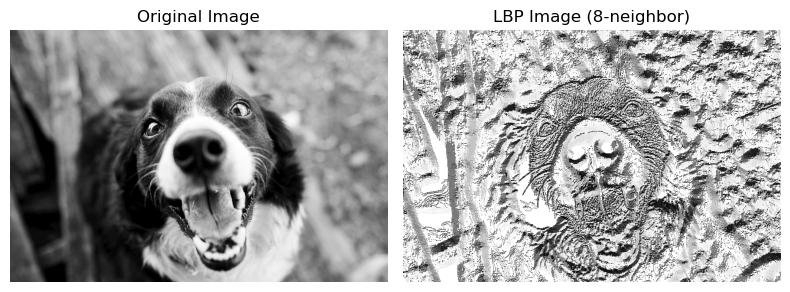

In [17]:
# Load image
original_image = iio.imread("img/grayscale/img1.png")

# Convert to grayscale if RGB
if original_image.ndim == 3:
    original_image = np.dot(original_image[..., :3], [0.299, 0.587, 0.114])

# Compute LBP
lbp_image = compute_lbp(original_image)

# Plot Original and LBP images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title("LBP Image (8-neighbor)")
plt.axis('off')

plt.tight_layout()
plt.show()


3. Write a Python function to compute the histogram of the LBP image.

In [18]:
def lbp_histogram(lbp_image, normalize=True):
    """Compute the histogram of an 8-neighbor LBP image."""
    # Flatten image and compute histogram (256 bins for 8-bit LBP)
    hist, bins = np.histogram(lbp_image.ravel(), bins=256, range=(0, 256))
    
    # Optionally normalize the histogram
    if normalize:
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-6)  # avoid division by zero

    return hist, bins

4. Plot the histogram and explain what it represents in terms of the texture features of the
image.

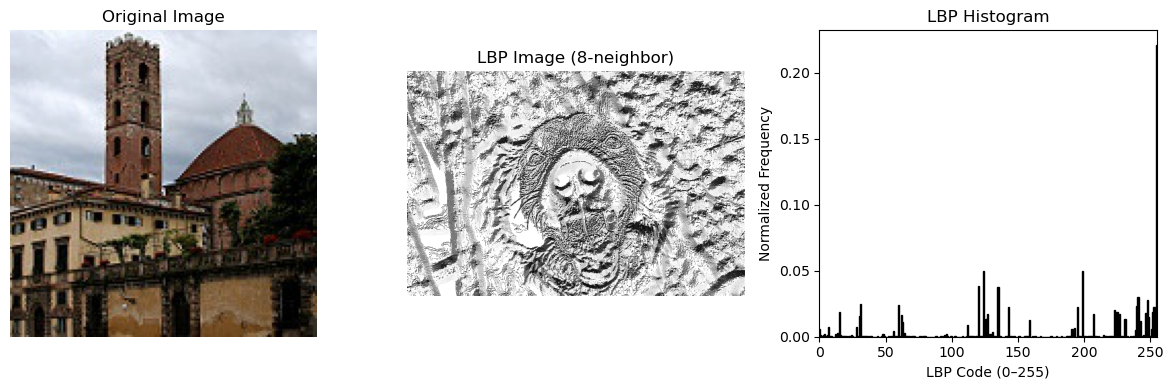

In [19]:
# Compute histogram
hist, bins = lbp_histogram(lbp_image, normalize=True)

# Create subplot layout
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# LBP image
axes[1].imshow(lbp_image, cmap='gray')
axes[1].set_title("LBP Image (8-neighbor)")
axes[1].axis('off')

# LBP histogram
axes[2].bar(np.arange(256), hist, width=1, color='black', edgecolor='black')
axes[2].set_title("LBP Histogram")
axes[2].set_xlabel("LBP Code (0–255)")
axes[2].set_ylabel("Normalized Frequency")
axes[2].set_xlim(0, 255)

plt.tight_layout()
plt.show()


This LBP histogram shows a strong peak near code ≈ 255, meaning many pixels have neighborhoods where all surrounding pixels are brighter than or equal to the center — typical of smooth or uniform regions with little local contrast.

The smaller peaks scattered across other codes indicate occasional edges or small texture variations, but the dominance of the high-value bin suggests the image’s overall texture is mostly flat and homogeneous, with few distinct local patterns or edges.

5. Apply your LBP function to at least three different grayscale images (e.g., a natural scene, a
texture, and a face image).

In [20]:
# Paths to images
folder_path = "img/lbp"

# List all files ending with .png in the folder, sorted alphabetically
images_paths = sorted(
    [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
)

# Compute LBP for each image
images, lbps = [], []
for p in images_paths:
    im = iio.imread(p)
    if im.ndim == 3:
        im = np.dot(im[..., :3], [0.299, 0.587, 0.114])
    images.append(im)
    lbps.append(compute_lbp(im))

6. Generate and compare the histograms of the LBP images.

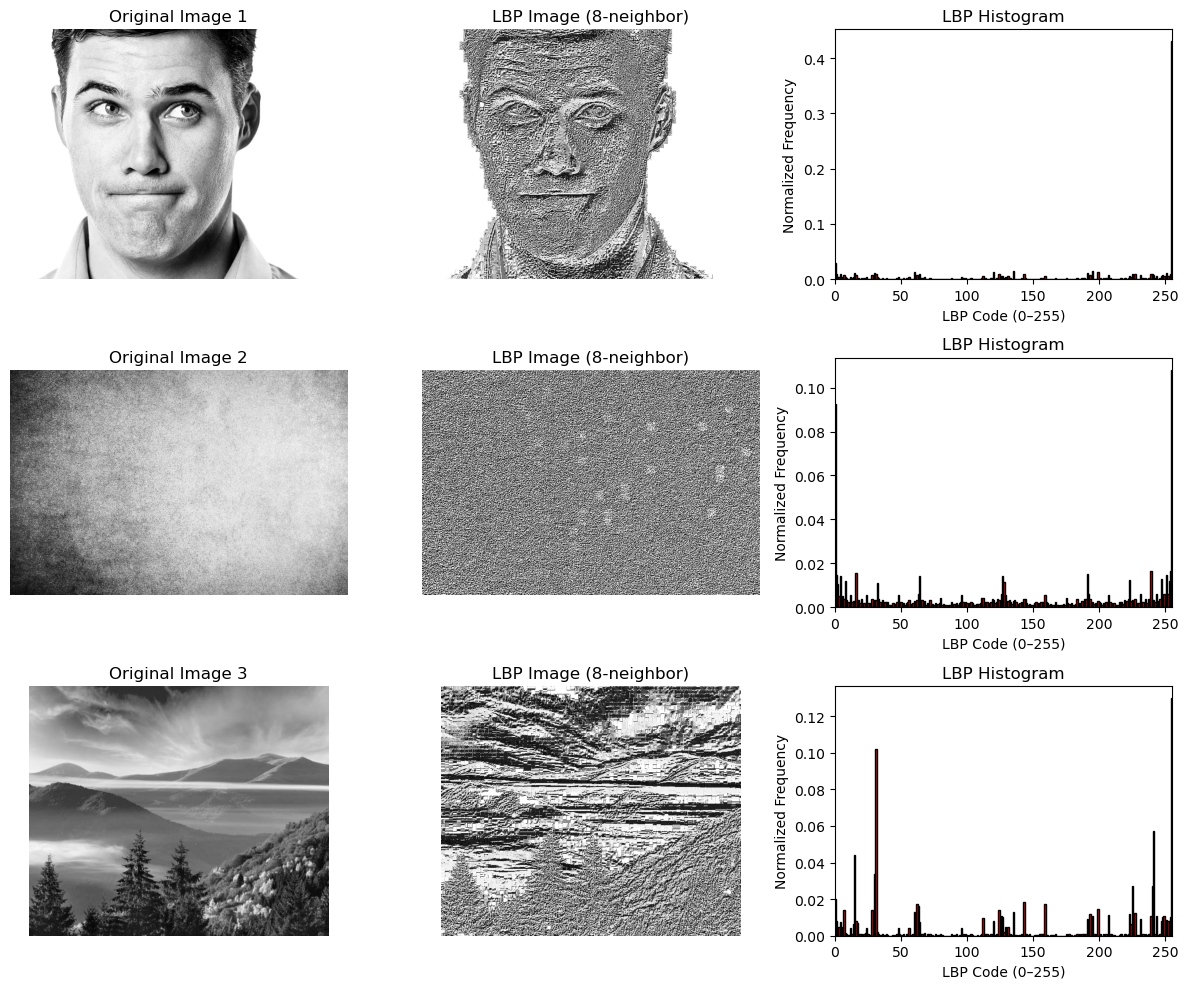

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for row, p in enumerate(images_paths):
    # Load and convert to grayscale if needed
    img = iio.imread(p)
    if img.ndim == 3:
        img = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    
    # Compute LBP and histogram
    lbp_image = compute_lbp(img)
    hist, bins = lbp_histogram(lbp_image, normalize=True)
   
    # Original image
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title(f"Original Image {row + 1}")
    axes[row, 0].axis('off')
    
    # LBP image
    axes[row, 1].imshow(lbp_image, cmap='gray')
    axes[row, 1].set_title("LBP Image (8-neighbor)")
    axes[row, 1].axis('off')
    
    # Histogram
    axes[row, 2].bar(np.arange(256), hist, width=1, color='red', edgecolor='black')
    axes[row, 2].set_title("LBP Histogram")
    axes[row, 2].set_xlim(0, 255)
    axes[row, 2].set_xlabel("LBP Code (0–255)")
    axes[row, 2].set_ylabel("Normalized Frequency")
    
plt.tight_layout()
plt.show()


7. Discuss the differences in the histograms and what they tell you about the textures of the
different images.

The LBP histograms reveal clear differences in texture complexity across the three images. The first image (face) shows a dominant peak near the highest LBP code, indicating large smooth areas with limited local contrast—typical of uniform skin regions and soft shading. The second image (texture surface) has a more evenly distributed histogram with moderate variation, reflecting a fine, grainy texture with small but consistent intensity changes across the surface. In contrast, the third image (natural scene) exhibits multiple pronounced peaks spread across the LBP range, signifying a rich mix of edges, patterns, and structural variations found in landscapes with trees, mountains, and shadows. Overall, narrower histograms correspond to smoother, more uniform textures, while broader, multi-peaked distributions indicate rougher and more complex textures.

## Implement a blob detection algorithm

1. Apply the blob detection algorithm to one of the provided image datasets on blackborad.

2. Visualize the detected blobs on the original images, marking each detected blob with a
circle or bounding box.

3. Calculate and display relevant statistics for each image, such as the number of blobs
detected, their sizes, and positions.

4. Evaluate and discuss the effect of different parameters in the algorithms on the detection of
different blobs.

## Implement a contour detection algorithm.

1. Apply the contour detection algorithm to the same image dataset.

2. Visualize the detected contours on the original images, marking each contour with a
different color.

3. Calculate and display relevant statistics for each image, such as the number of contours
detected, contour area, and perimeter.

4. Compare the results of blob detection and contour detection for the chosen dataset.

5. Discuss the advantages and limitations of each technique.





6. Analyze the impact of different parameters (e.g., threshold values, filter sizes) on the
detection results.

7. Provide examples where one technique might be more suitable than the other.